# Tutorial. Numerical solution of a partial differential equation using a collocation spectral method

In this notebook, a collocation spectral methods is used to solve an initial-value problem for a linear partial differential equation. Two algorithmic approaches are considered: one using the fast Fourier transform, the other involving multiplication by a differentiation matrix.

The following libraries will be needed, notably `fft` from <tt>scipy</tt>, notably for a computationally efficient implementation of the Chebyshev transform.

In [1]:
import numpy as np
import scipy as scp
from scipy import fft

# To draw matplotlib plots within this notebook.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from python_code.nord_cmap import * 
from typing import Iterable, Callable

## Exercise 1. Differentiation in collocation spectral methods: fast Fourier transforms versus matrix multiplication.

When implementing a collocation spectral method for the solution of a partial differential equation problem, Fourier or chebyshev interpolation differentiation at the collocation points can be performed using matrix multiplication, rather than resorting to fast Fourier transform.

Fourier interpolation differentiation can indeed be represented by a matrix, called the *Fourier interpolation derivative matrix* $D_N$, such that the approximate value of the first derivative of a function $u$ at the collocation point $x_j=\frac{2\pi j}{N}$, $j=0,\dots,N-1$, with $N$ an *even* non-zero natural integer, is given by
$$
\sum_{l=0}^{N-1}\left(D_N^{(1)}\right)_{jl}u(x_l),
$$
where
$$
\left(D_N^{(1)}\right)_{jl}=\frac{1}{N}\sum_{k=-N/2+1}^{N/2}ike^{2ik\frac{(j-l)\pi}{N}}.
$$
Note here that the indices of the elements of the matrix start at value zero, like in the indexing of arrays in Python.

If $u$ is a real function, the last sum can be evaluated in closed form and, in practice, one has
$$
\left(D_N^{(1)}\right)_{jl}=\begin{cases}\frac{1}{2}(-1)^{j+l}\cot\left(\frac{(j-l)\pi}{N}\right)&\text{if }j\neq l,\\0&\text{if }j=l.\end{cases}
$$
One may notice that this matrix is a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix). 

**Question.** Write a program for the differentiation of a discrete Fourier series approximation of the function $u(x)=\exp(\sin(x))$ using matrix multiplication (note the `linalg` library from <tt>scipy</tt> possesses a function for the construction of a Toeplitz matrix, see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.toeplitz.html)). Compare its accuracy and execution time to that of the code for differentiation based on the Fast Fourier transform, written in a previous tutorial, for several values of $N$ and using the `time` function in the `time` library (see the [documentation](https://docs.python.org/3/library/time.html#time.time)).

In [2]:
from time import time

In [3]:
from fourrier import * 

In [4]:
def compute_FIDM(N) : 
    
    j = np.arange(1,N)
    first_column = np.insert(1/2 * (-1) ** j * 1/np.tan(j * np.pi / N),0,0)
    first_row = - first_column
    
    FIDM = scp.linalg.toeplitz(first_column, first_row)
    
    return FIDM
    

In [5]:
def u(x) : return np.exp(np.sin(x))
def u_p(x) : return np.cos(x) * np.exp(np.sin(x))

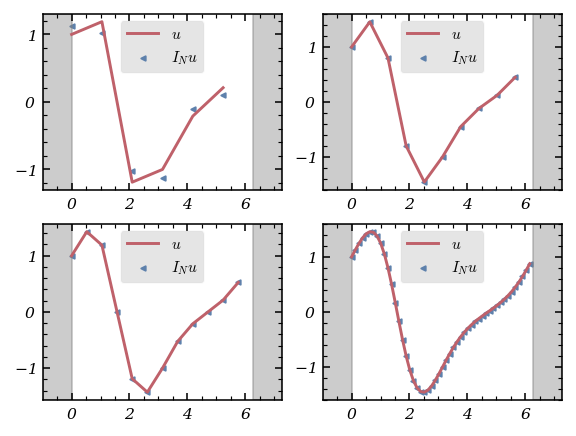

In [10]:
fig, axes = plt.subplots(2,2, figsize = (4,3))
color = color_list(2)
N = [6, 10, 12, 50, 80, 100, *[2 ** k for k in range(3, 12)]]

time_mat = []
time_fft = []

error_mat = []
error_fft = []

for k in range(len(N)) :
     
    collocation = np.arange(N[k]) * 2 * np.pi / N[k]
    t0 = time()
    interp1 = compute_FIDM(N[k]) @ u(collocation)
    time_mat.append(time()- t0)
    
    t0 = time()
    x = np.linspace(-.99,.99, 100)
    interp2 = der_interpolant(compute_dct_coeff(N[k],u), x)
    time_fft.append(time()- t0)
    
    error_mat.append(np.max(np.abs(u_p(collocation) - interp1)))
    error_fft.append(np.max(np.abs(u_p(x) - interp2)))

for k,ax in enumerate(axes.flat) : 

    collocation = np.arange(N[k]) * 2 * np.pi / N[k]
    interp1 = compute_FIDM(N[k]) @ u(collocation)
    
    
    ax.plot(collocation,u_p(collocation), color = color[1], label = '$u$')
    ax.scatter(collocation, interp1,s = 5, marker = '<',color = color[0], label = '$I_N u $')

    ax.set_xlim(-1, 2 * np.pi + 1)
    ax.axvspan(2 * np.pi, 2 * np.pi + 1, color = 'grey', alpha = .4)
    ax.axvspan(-1,0, color = 'grey', alpha = .4)
    ax.legend()

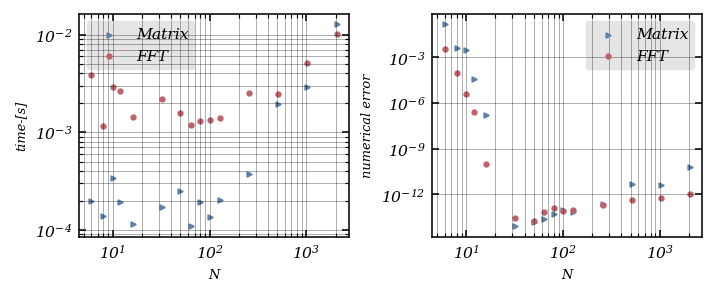

In [28]:

fig, ax = plt.subplots(1,2, figsize = (5,2))

ax[0].scatter(N, time_mat, color = color[0], s = 5, marker = '>', label = 'Matrix')
ax[0].scatter(N, time_fft, color = color[1], s = 5, marker = 'o', label = 'FFT')
ax[0].set_xlabel('N')
ax[0].set_ylabel('time-[s]')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid(which = 'both', alpha = .4)

ax[1].scatter(N, error_mat, color = color[0], s = 5, marker = '>', label = 'Matrix')
ax[1].scatter(N, error_fft, color = color[1], s = 5, marker = 'o', label = 'FFT')

ax[1].set_xlabel('N')
ax[1].set_ylabel('numerical error')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(which = 'both', alpha = .4)

ax[1].legend()


**Answer.**

For non periodic functions, the Chebyshev interpolation differentiation can be also achieved using a matrix. In this case, C can be written in closed-form, and one has
$$
\left(D_N^{(1)}\right)_{jl}=\begin{cases}\dfrac{2N^2+1}{6}&j=l=0,\\-\dfrac{x_j}{2(1-{x_j}^2)}&1\leq j,l\leq N-1,\ j=l\\\dfrac{c_i}{c_j}\dfrac{(-1)^{j+l}}{x_j-x_l}&1\leq j,l\leq N-1,\ j\neq l,\\-\dfrac{2N^2+1}{6}&j=l=N,\end{cases}
$$
where
$$
c_j=\begin{cases}2&\text{if }j=0\text{ or }N,\\1,&\text{if }j=1,\dots,N-1,\end{cases}\text{ and }x_j=\cos\left(\frac{\pi j}{N}\right),\ j=0,\dots,N.
$$

**Question.** Write a program for the differentiation of a discrete Chebyshev series approximation of the function $u(x)=\exp(-x^2)$ using matrix multiplication. Compare its accuracy and execution time to that of the code for differentiation based on the Fast Fourier transform, written in a previous tutorial, for several values of $N$.

In [29]:
def compute_FIDM_np(N) : 
    
    x = np.cos(np.pi * np.arange(N + 1) / N )
    c = np.insert(np.ones(N-1),[0,N-1], [2,2])

    D_N = np.empty(shape = (N+1, N+1))
    
    for j in range(N + 1) : 
        for l in range(N + 1) : 
            
            if j == 0 and l == 0 : 
                
                D_N[j,l] = (2 * N ** 2 + 1) / 6 
            
            if j == N and l == N : 
                
                D_N[j,l] = - (2 * N ** 2 + 1) / 6 
                
            if j == l and j < N and j > 0 : 
                
                D_N[j,l] = - x[j] / (2 * (1 - x[j] ** 2))
            
            if j != l : 

                D_N[j,l] =  c[j]/c[l] * ((-1) ** (j + l)) / (x[j] - x[l])
    
    return D_N
                

In [30]:
def u(x) : return np.exp(- x ** 2)
def u_p(x) : return - 2 * x * np.exp(- x ** 2)

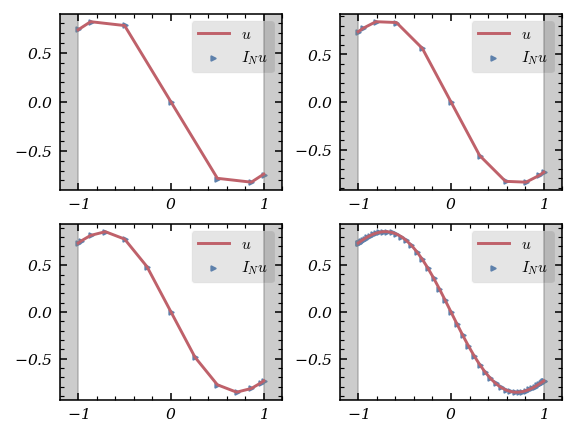

In [32]:
fig, axes = plt.subplots(2,2, figsize = (4,3))
color = color_list(2)
N = [6, 10, 12, 50, 80, 100, *[2 ** k for k in range(3, 12)]]

time_mat = []
time_fft = []

error_mat = []
error_fft = []

for k in range(len(N)) :
     
    collocation = np.cos(np.pi * np.arange(N[k] + 1) / N[k] )
    t0 = time()
    interp1 =compute_FIDM_np(N[k]) @ u(collocation)
    time_mat.append(time()- t0)
    
    t0 = time()
    x = np.linspace(-.99,.99, 100)
    interp2 = der_interpolant(compute_dct_coeff(N[k],u), x)
    time_fft.append(time()- t0)
    
    error_mat.append(np.max(np.abs(u_p(collocation) - interp1)))
    error_fft.append(np.max(np.abs(u_p(x) - interp2)))
    
for k,ax in enumerate(axes.flat) : 

    collocation = np.cos(np.pi * np.arange(N[k] + 1) / N[k] )
    ax.plot(collocation,u_p(collocation), color = color[1], label = '$u$')
    ax.scatter(collocation, compute_FIDM_np(N[k]) @ u(collocation), s= 5, marker = '>', color = color[0], label = '$I_N u $')
    
    ax.set_xlim(-1.2, 1.2)
    ax.axvspan(-1.2, -1, color = 'grey', alpha = .4)
    ax.axvspan(1,1.2, color = 'grey', alpha = .4)
    ax.legend()

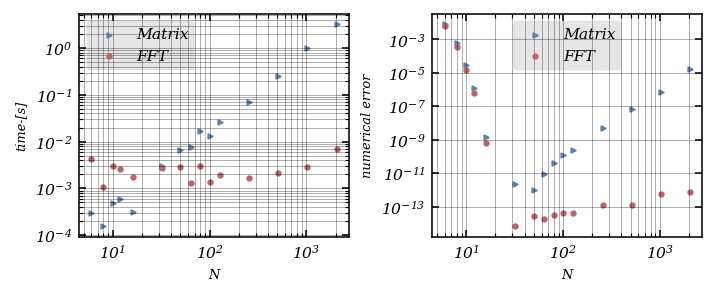

In [33]:

fig, ax = plt.subplots(1,2, figsize = (5,2))

ax[0].scatter(N, time_mat, color = color[0], s = 5, marker = '>', label = 'Matrix')
ax[0].scatter(N, time_fft, color = color[1], s = 5, marker = 'o', label = 'FFT')
ax[0].set_xlabel('N')
ax[0].set_ylabel('time-[s]')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid(which = 'both', alpha = .4)

ax[1].scatter(N, error_mat, color = color[0], s = 5, marker = '>', label = 'Matrix')
ax[1].scatter(N, error_fft, color = color[1], s = 5, marker = 'o', label = 'FFT')

ax[1].set_xlabel('N')
ax[1].set_ylabel('numerical error')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(which = 'both', alpha = .4)

ax[1].legend()


**Answer.**


## Exercise 2. Numerical solution of a linear wave equation using a Chebyshev collocation spectral method.

In this exercise, we are interested in the numerical solution of an initial-value problem for a linear wave equation set in a two-dimensional domain,
$$
\frac{\partial^2u}{\partial t^2}(t,x,y)-\left(\frac{\partial^2u}{\partial x^2}(t,x,y)+\frac{\partial^2u}{\partial y^2}(t,x,y)\right)=0,\ (x,y)\in(-1,1)^2,\ t\in(0,+\infty),
$$
with homogeneous Dirichlet boundary conditions
$$
\forall t\in[0,+\infty),\ \forall y\in(-1,1),\ u(t,\pm1,y)=0\text{ and }\forall x\in(-1,1),\ u(t,x,\pm1)=0,
$$
and initial conditions
$$
\forall(x,y)\in(-1,1)^2,\ u(0,x,y)=e^{-40((x-0.4)^2+y^2)},\ \frac{\partial u}{\partial t}(0,x,y)=0,
$$
using a Chebyshev collocation spectral method in space and a leap-frog discretisation in time (this is the so-called [method of lines](https://en.wikipedia.org/wiki/Method_of_lines)). Note that the data for initial condition do not satisfy the boundary conditions in theory, but do so at the numerical level.

**Question.** Give the formula for the values of the second-order Chebyshev interpolation derivative of a function $u$ at the interior Chebyshev-Gauss-Lobatto points in terms of the discrete Chebyshev coefficients of the function.

**Answer.**

**Question.** Propose an algorithm with $O(N\log_2(N))$ complexity to compute these values using functions from the `fft` library of <tt>scipy</tt>.

**Answer.**

**Question.** Use this algorithm in a program solving the above initial-value problem up to time $T=10$ using a Chebyshev collocation spectral method for the space discretisation (choosing $N=32$ for instance) and a leap-frog scheme for the time discretisation. The choice of time-step length will be such that it satisfies a CFL-like condition of the form $\Delta t\leq C N^{-2}$, with $C$ a positive constant such that $C\leq 6.5$ (this condition follows from the determination of the stability region of the leap-frog and of the largest eigenvalue of the space discretisation operator). The result may be plotted as an animation.

In [ ]:
# for animations
matplotlib.rcParams['animation.embed_limit']=2**128
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation
from IPython.display import HTML

In [ ]:
# plot the result as an animation
fig,ax=plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlim((-1.,1))
ax.set_xlabel(r'$x$')
ax.set_ylim((-1.,1.))
ax.set_ylabel(r'$y$')
ax.set_zlim((-1.,1.))
ax.set_zlabel(r'$u(t,x,y)$')

def animate(i,zarray,frame):
    frame[0].remove()
    frame[0]=ax.plot_surface(xx,yy,zarray[i,:,:],rstride=1,cstride=1,cmap=cm.autumn,edgecolor='black')
    ax.set_title(r't='+f'{i*dt:.1f}')

frame=[ax.plot_surface(xx,yy,V[0,:,:],rstride=1,cstride=1,cmap=cm.autumn,edgecolor='black')]

anim=animation.FuncAnimation(fig,animate,nplots,fargs=(V,frame),interval=10)
HTML(anim.to_jshtml())

Second-order Chebyshev interpolation differentiation can be achieved using the matrix given by
$$
\left(D_N^{(2)}\right)_{jl}=\begin{cases}\dfrac{(-1)^{j+l}}{c_l}\dfrac{{x_j}^2+x_jx_l-2}{(1-{x_j}^2)(x_j-x_l)^2},&1\leq j\leq N-1,\ 0\leq l\leq N,\ j\neq l,\\-\dfrac{(N^2-1)(1-{x_j}^2)+3}{3(1-{x_j}^2)^2},&1\leq j,l\leq N-1,\ j=l,\\\dfrac{2}{3}\dfrac{(-1)^l}{c_l}\dfrac{(2N^2+1)(1-x_l)-6}{(1-x_l)^2},&j=0,\ 1\leq l\leq N,\\\dfrac{2}{3}\dfrac{(-1)^{l+N}}{c_l}\dfrac{(2N^2+1)(1+x_l)-6}{(1+x_l)^2},&j=N,\ 0\leq l\leq N-1\\\dfrac{N^4-1}{15},&j=l=0\text{ or }N,\end{cases}
$$
where
$$
c_j=\begin{cases}2,&j=0\text{ or }N,\\1,&j=1,\dots,N-1.\end{cases}
$$
To ease the implementation in this notebook, we note that this matrix can be obtained as the square of the first-order Chebyshev differentiation matrix, at the cost of $O(N^3)$ operations, the latter having the form already seen in the preceding exercise:
$$
\left(D_N^{(1)}\right)_{jl}=\begin{cases}\dfrac{2N^2+1}{6}&j=l=0,\\-\dfrac{x_j}{2(1-{x_j}^2)}&1\leq j,l\leq N-1,\ j=l\\\dfrac{c_i}{c_j}\dfrac{(-1)^{j+l}}{x_j-x_l}&1\leq j,l\leq N-1,\ j\neq l,\\-\dfrac{2N^2+1}{6}&j=l=N.\end{cases}
$$
**Question.** Modify the previous program to make use of matrix multiplications instead of fast Fourier transforms.